In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
import numpy as np
import geopandas as gpd
from matplotlib.patches import Rectangle
from utils.geotif_io import readTiff
from utils.imgShow import imgShow
from utils.raster_vec import vec2mask
from matplotlib.colors import LinearSegmentedColormap


### 1. Surface water occurrence in representative region.

In [2]:
path_wat_occ = 'data/tibet/tibet_result/s1_wat_occ_200m.tif'
path_tibet_boundry = 'data/tibet/tibet-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp'


In [3]:
wat_occ, wat_occ_info= readTiff(path_wat_occ)
wat_occ = np.nan_to_num(wat_occ, 0)  ## convert np.nan to 0


In [4]:
wat_occ.shape


(7790, 17213)

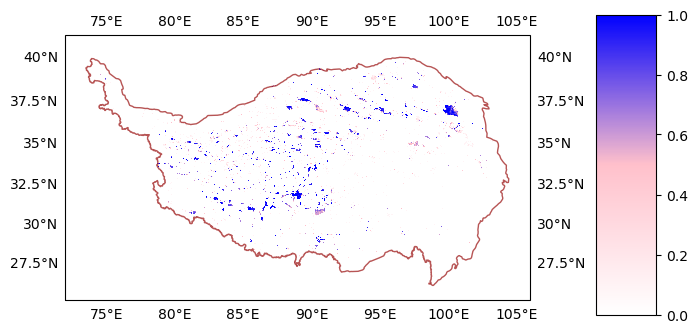

In [8]:
cmap_water = LinearSegmentedColormap.from_list('linear color', ["White", 'Pink', 'Blue'])

def reg2patch(sub_region, proj=None):
  ## region: list contain 4 location values, \
  #           that is [row_start, row_end, col_start, col_end]
  x0, y0, width, height = sub_region[2], sub_region[0], \
                      sub_region[3]-sub_region[2], sub_region[1]-sub_region[0] # (x0,y0) is the up-left point.
  rect = Rectangle((x0, y0), width, height, linewidth=1, 
                  edgecolor='Magenta', 
                  facecolor='none', 
                  transform=proj)
  return rect

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=88.5))

ax.set_extent([72, 106, 25.0, 40.0])
# 1. tibet boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_tibet_boundry).geometries(), \
                              crs=ccrs.PlateCarree(), edgecolor='Brown', alpha=0.8, \
                              linestyle='-', linewidth=1, facecolor='none')
ax.add_feature(shp_fea, zorder=2)

### 2. water occurrence map
ax_water = ax.imshow(wat_occ, extent=wat_occ_info['geoextent'], \
                                  vmin=0, vmax=1, interpolation='none', \
                                  cmap=cmap_water, transform=ccrs.PlateCarree(), zorder=1)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1, linestyle='--')
gl.xlines = False; gl.ylines = False
cax = fig.add_axes([1.01, 0.25, 0.1, 0.5]); fig.colorbar(ax_water, cax=cax)

## 3. plot sub-region
sub_region_1 = [31.81, 31.18, 90.48, 91.32]    ## row_start, row_end, col_start, col_end
sub_region_2 = [37.98, 37.27, 93.07, 94.15]    ## row_start, row_end, col_start, col_end
sub_region_3 = [33.55, 33.28, 102.24, 102.61]  ## row_start, row_end, col_start, col_end
rect_1 = reg2patch(sub_region_1, proj=ccrs.PlateCarree())
rect_2 = reg2patch(sub_region_2, proj=ccrs.PlateCarree())
rect_3 = reg2patch(sub_region_3, proj=ccrs.PlateCarree())
# ax.add_patch(rect_1); ax.add_patch(rect_2); ax.add_patch(rect_3)



### 2. Surface water map in overall tibet plateau

In [6]:
path_tibet_shp =  'data/tibet/tibet-boundary/TPBoundary_HF/TPBoundary_HF_wgs84.shp'
path_tb_tiles_water = 'data/tibet/tibet_result/tb_tiles_wat_stat.shp'
path_tb_basins_water = 'data/tibet/tibet_result/tb_basins_stat.shp'



### Tile-based water mapping

In [7]:
geodf_tb_tiles_water = gpd.read_file(path_tb_tiles_water)
geodf_tb_tiles = gpd.read_file(path_tibet_shp)
geodf_tb_tiles_water.head(1)
print(geodf_tb_tiles_water.columns)


Index(['01_wat_per', '02_wat_per', '12_wat', '03_wat', '09_wat', '06_wat_per',
       '99_std_per', '05_wat_per', '08_wat', '04_wat_per', '04_wat',
       '03_wat_per', '01_wat', '10_wat', '10_wat_per', 'tile_id', '07_wat',
       '05_wat', '07_wat_per', '11_wat', '08_wat_per', '02_wat', '11_wat_per',
       '12_wat_per', 'tile_area', '09_wat_per', '06_wat', 'geometry'],
      dtype='object')


### Monthly surface water visualization

Text(0.06, 0.09, 'Std.')

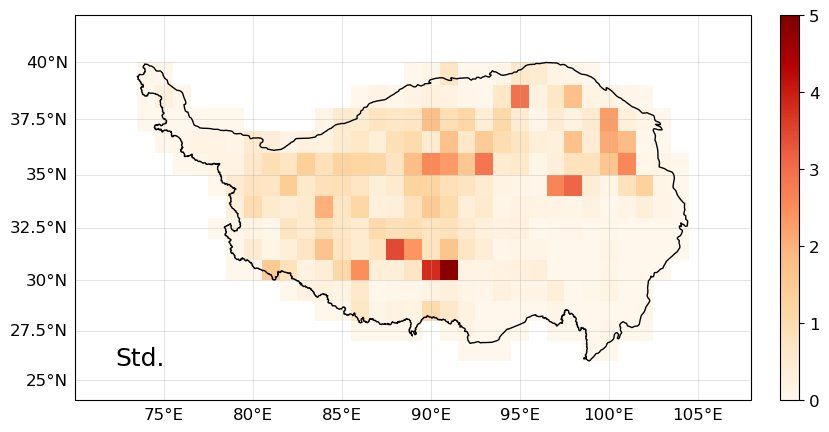

In [8]:
crs_1 = ccrs.Mercator(central_longitude=89)
crs_2 = ccrs.epsg('3857')
plt.rcParams.update({'font.size': 12})
cmap_num = LinearSegmentedColormap.from_list('linear color', ["White", 'Wheat', "Brown"])
fig = plt.figure(figsize=(16, 5))
ax_1 = fig.add_subplot(1, 1, 1, projection=crs_2)
ax_1.set_extent([70, 108, 24.0, 42.0])
ax_1.add_geometries(geodf_tb_tiles.to_crs(epsg=3857)['geometry'], crs=crs_2, facecolor='none', edgecolor='black' )
ax_1 = geodf_tb_tiles_water.to_crs(epsg=3857).plot(column='99_std_per', ax=ax_1, \
                                  legend=True, vmin=0, vmax=5,
                                  legend_kwds={'anchor': (-0.2, 0.5)}, cmap='OrRd');
grid = ax_1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
grid.xlabels_top = False
grid.ylabels_right = False

ax_1.text(0.06, 0.09, 'Std.', fontsize=18, transform=ax_1.transAxes)
# # plt.savefig(config.root_proj + '/figure/std_wat_maps.png', bbox_inches='tight')


Text(0.06, 0.09, 'Dec.')

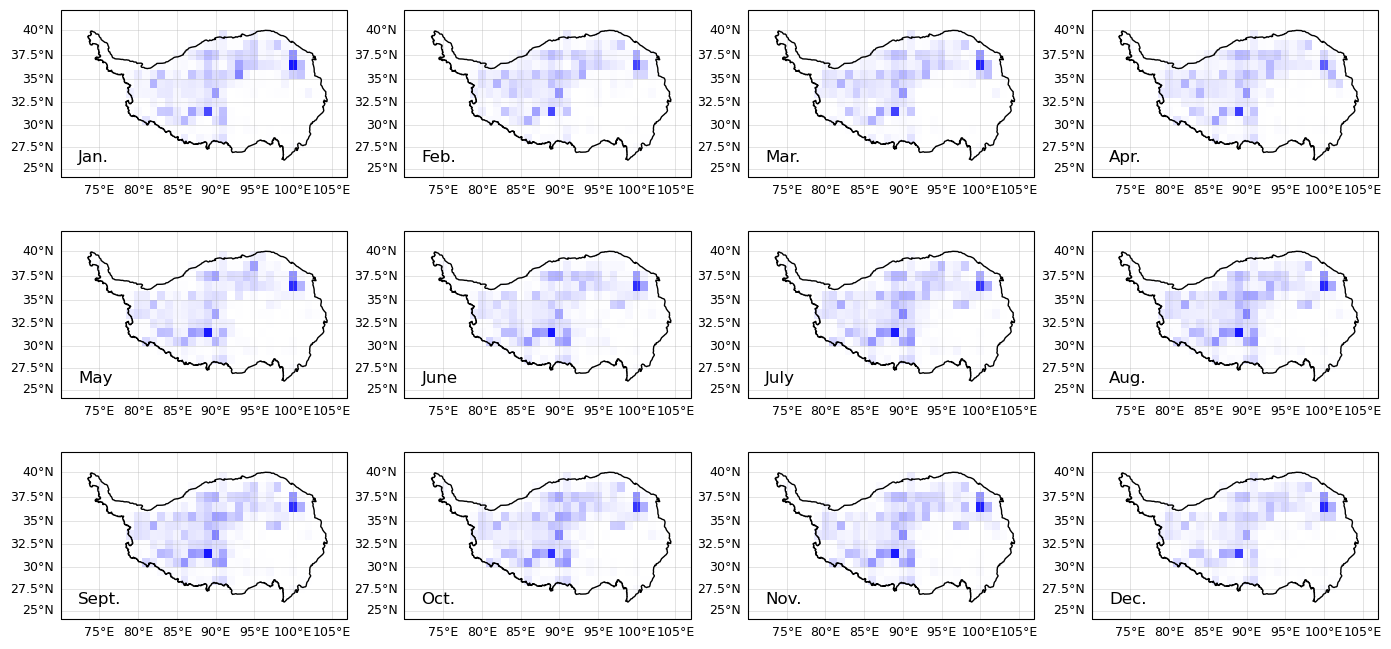

In [9]:
crs_2 = ccrs.epsg('3857')
cmap_water = LinearSegmentedColormap.from_list('linear color', ["White", 'Blue'])

plt.rcParams.update({'font.size': 9})

def plot_wat_map(geodf_tibet=geodf_tb_tiles, geodf_tibet_water=geodf_tb_tiles_water, ax=None, col='01_wat_per'):
  ax.set_extent([70, 107, 24.0, 42.0])
  ax.add_geometries(geodf_tibet.to_crs(epsg=3857)['geometry'], crs=crs_2, facecolor='none', edgecolor='black' )
  ax = geodf_tibet_water.to_crs(epsg=3857).plot(column=col, ax=ax, \
                                    legend=False, vmax=30, vmin=0,
                                    legend_kwds={'anchor': (0.3, 0.5)}, cmap=cmap_water);
  grid = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
  grid.xlabels_top = False
  grid.ylabels_right = False


fig = plt.figure(figsize=(17, 11))
ax_1 = fig.add_subplot(4, 4, 1, projection=crs_2)
plot_wat_map(ax=ax_1, col='01_wat_per')
ax_1.text(0.06, 0.09, 'Jan.', fontsize=12, transform=ax_1.transAxes)
ax_2 = fig.add_subplot(4, 4, 2, projection=crs_2)
plot_wat_map(ax=ax_2, col='02_wat_per')
ax_2.text(0.06, 0.09, 'Feb.', fontsize=12, transform=ax_2.transAxes)
ax_3 = fig.add_subplot(4, 4, 3, projection=crs_2)
plot_wat_map(ax=ax_3, col='03_wat_per')
ax_3.text(0.06, 0.09, 'Mar.', fontsize=12, transform=ax_3.transAxes)
ax_4 = fig.add_subplot(4, 4, 4, projection=crs_2)
plot_wat_map(ax=ax_4, col='04_wat_per')
ax_4.text(0.06, 0.09, 'Apr.', fontsize=12, transform=ax_4.transAxes)

ax_5 = fig.add_subplot(4, 4, 5, projection=crs_2)
plot_wat_map(ax=ax_5, col='05_wat_per')
ax_5.text(0.06, 0.09, 'May', fontsize=12, transform=ax_5.transAxes)
ax_6 = fig.add_subplot(4, 4, 6, projection=crs_2)
plot_wat_map(ax=ax_6, col='06_wat_per')
ax_6.text(0.06, 0.09, 'June', fontsize=12, transform=ax_6.transAxes)
ax_7 = fig.add_subplot(4, 4, 7, projection=crs_2)
plot_wat_map(ax=ax_7, col='07_wat_per')
ax_7.text(0.06, 0.09, 'July', fontsize=12, transform=ax_7.transAxes)
ax_8 = fig.add_subplot(4, 4, 8, projection=crs_2)
plot_wat_map(ax=ax_8, col='08_wat_per')
ax_8.text(0.06, 0.09, 'Aug.', fontsize=12, transform=ax_8.transAxes)

ax_9 = fig.add_subplot(4, 4, 9, projection=crs_2)
plot_wat_map(ax=ax_9, col='09_wat_per')
ax_9.text(0.06, 0.09, 'Sept.', fontsize=12, transform=ax_9.transAxes)
ax_10 = fig.add_subplot(4, 4, 10, projection=crs_2)
plot_wat_map(ax=ax_10, col='10_wat_per')
ax_10.text(0.06, 0.09, 'Oct.', fontsize=12, transform=ax_10.transAxes)
ax_11 = fig.add_subplot(4, 4, 11, projection=crs_2)
plot_wat_map(ax=ax_11, col='11_wat_per')
ax_11.text(0.06, 0.09, 'Nov.', fontsize=12, transform=ax_11.transAxes)
ax_12 = fig.add_subplot(4, 4, 12, projection=crs_2)
plot_wat_map(ax=ax_12, col='12_wat_per')
ax_12.text(0.06, 0.09, 'Dec.', fontsize=12, transform=ax_12.transAxes)
# plt.savefig(config.root_proj + '/figure/study_area.png', bbox_inches='tight')



### Basin-based water mapping

In [10]:
geodf_tb_basins_water = gpd.read_file(path_tb_basins_water)
geodf_tb = gpd.read_file(path_tibet_shp)
geodf_tb_basins_water.head(1)
print(geodf_tb_basins_water.columns)


Index(['fid', '01_wat_per', '02_wat_per', '12_wat', 'DN', '03_wat', '09_wat',
       '06_wat_per', '99_std_per', 'ENDO', '05_wat_per', 'basin_name',
       '08_wat', '04_wat_per', '04_wat', '03_wat_per', 'area', '01_wat',
       '10_wat', '10_wat_per', '07_wat', '05_wat', '07_wat_per', '11_wat',
       '08_wat_per', '02_wat', '11_wat_per', '12_wat_per', '09_wat_per',
       '06_wat', 'geometry'],
      dtype='object')


Text(0.06, 0.09, 'Std.')

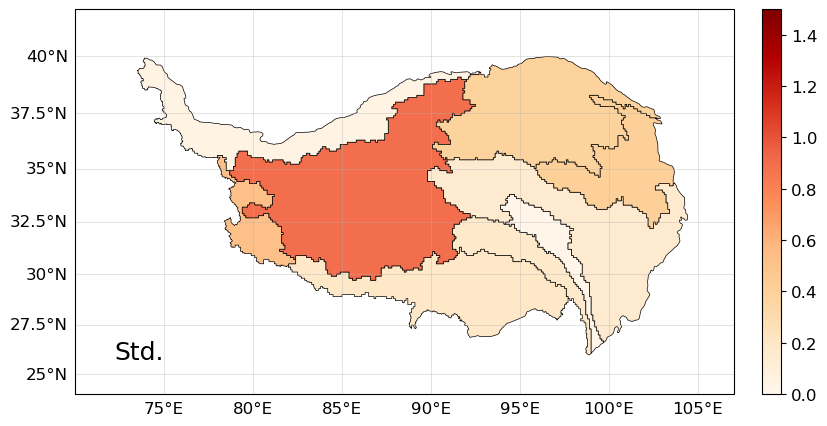

In [11]:
crs_1 = ccrs.Mercator(central_longitude=89)
crs_2 = ccrs.epsg('3857')
plt.rcParams.update({'font.size': 12})
cmap_num = LinearSegmentedColormap.from_list('linear color', ["White", 'Wheat', "Brown"])
fig = plt.figure(figsize=(16, 5))
ax_1 = fig.add_subplot(1, 1, 1, projection=crs_2)
ax_1.set_extent([70, 107, 24.0, 42.0])
ax_1 = geodf_tb_basins_water.to_crs(epsg=3857).plot(column='99_std_per', ax=ax_1, \
                                  legend=True, vmin=0, vmax=1.5, edgecolor='black', linewidth=0.5, 
                                  legend_kwds={'anchor': (-0.2, 0.5)}, cmap='OrRd');
grid = ax_1.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
grid.xlabels_top = False
grid.ylabels_right = False
ax_1.text(0.06, 0.09, 'Std.', fontsize=18, transform=ax_1.transAxes)
# plt.savefig(config.root_proj + '/figure/std_wat_maps.png', bbox_inches='tight')



Text(0.06, 0.09, 'Wet season (Aug.)')

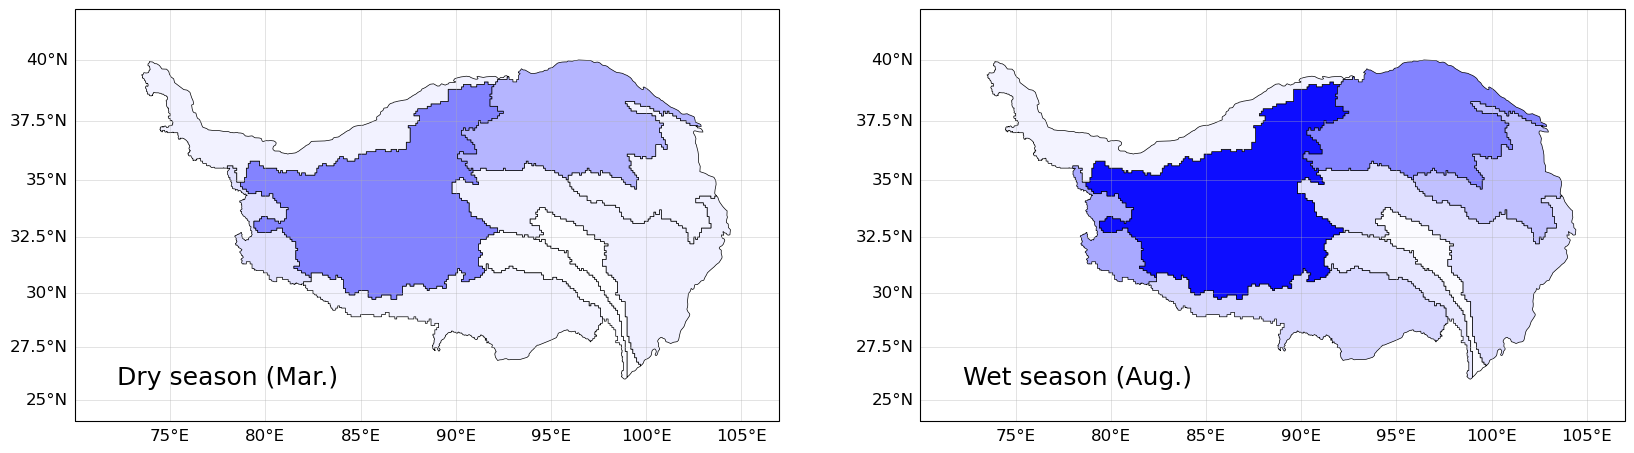

In [12]:
def plot_wat_map_(geodf_tibet_water=geodf_tb_tiles_water, ax=None, col='01_wat_per'):
  ax.set_extent([70, 107, 24.0, 42.0])
  ax = geodf_tibet_water.to_crs(epsg=3857).plot(column=col, ax=ax, \
                                    legend=False, vmin=0, vmax=5, 
                                    edgecolor='black', linewidth=0.5, 
                                    legend_kwds={'anchor': (0.3, 0.5)}, cmap=cmap_water);
  grid = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, zorder=1)
  grid.xlabels_top = False
  grid.ylabels_right = False
  return ax

fig = plt.figure(figsize=(20, 8))
ax_1 = fig.add_subplot(1, 2, 1, projection=crs_2)
plot_wat_map_(geodf_tibet_water=geodf_tb_basins_water, ax=ax_1, col='03_wat_per')
ax_1.text(0.06, 0.09, 'Dry season (Mar.)', fontsize=18, transform=ax_1.transAxes)

ax_2 = fig.add_subplot(1, 2, 2, projection=crs_2)
plot_wat_map_(geodf_tibet_water=geodf_tb_basins_water, ax=ax_2, col='08_wat_per')
ax_2.text(0.06, 0.09, 'Wet season (Aug.)', fontsize=18, transform=ax_2.transAxes)
# plt.colorbar(ax_, fraction=0.025, pad=0.15, label='water percentage')  #



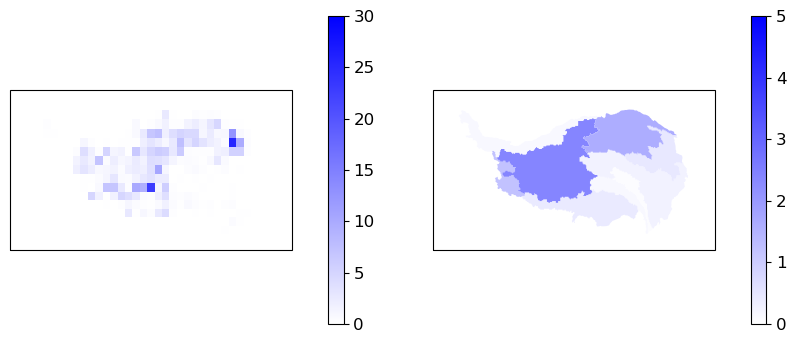

In [13]:
### Colorbar 
fig = plt.figure(figsize=(10, 4))
ax_1 = fig.add_subplot(1, 2, 1, projection=crs_2)
ax_1.set_extent([70, 108, 24.0, 42.0])
ax_1 = geodf_tb_tiles_water.to_crs(epsg=3857).plot(column='12_wat_per', ax=ax_1, \
                          legend=True, vmin=0, vmax=30,
                          legend_kwds={'anchor': (0.5, -0.25)}, cmap=cmap_water);

ax_2 = fig.add_subplot(1, 2, 2, projection=crs_2)
ax_2.set_extent([70, 108, 24.0, 42.0])
ax_2 = geodf_tb_basins_water.to_crs(epsg=3857).plot(column='12_wat_per', ax=ax_2, \
                          legend=True, vmin=0, vmax=5, 
                          legend_kwds={'anchor': (0.5, -0.25)}, cmap=cmap_water);
                                                